# 5 Qubit Code Under Random Pauli Error

In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import pylatexenc

from qiskit_aer import AerSimulator
from qiskit import transpile

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector, Pauli
from qiskit.visualization import plot_histogram

## Preparing the Logical State for 5-Qubit Code

We want to construct the logical state $|x_L\rangle$, with $x\in \{0,1\}$, for the quantum error correcting code $[[5,1,3]]$. 

### The Logical 0 State

According to [Quantum Error Correction: An Introductor Guide](https://iontrap.duke.edu/files/2025/03/arxiv_sub_v2.pdf), the logical 0 state $|0_L\rangle$ in a $[[n,k,d]]$ quantum error correcting code is given by
$$|0_L\rangle = \frac{1}{N}\prod\limits_{P_i\in \mathcal{S}}(I_2^{\otimes n}+P_i)|0^{\otimes n}\rangle$$
where $\mathcal{S}$ is the generating set of stabilizers and $\frac{1}{N}$ is the normalizing factor. Note that 
$$\begin{align*}
    |0_L\rangle &= \frac{1}{N}\prod\limits_{P_i\in \mathcal{S}}(I_2^{\otimes n}+P_i)|0^{\otimes n}\rangle \\
    &= \frac{1}{N}\left(|0^{\otimes n}\rangle + P_1|0^{\otimes n}\rangle + ... + P_{|\mathcal{S}|}|0^{\otimes n}\rangle + P_1P_2|0^{\otimes n}\rangle + ... + P_1P_{|\mathcal{S}|}|0^{\otimes n}\rangle + ...... + P_1P_2...P_{|\mathcal{S}|}|0^{\otimes n}\rangle\right).
\end{align*}$$

Recall that the stabilizer group of the $[[5,1,3]]$ quantum error correcting code is generated by the elements 
$$\begin{align*}
    P_1 &= XZZXI \\
    P_2 &= IXZZX \\
    P_3 &= XIXZZ \\
    P_4 &= ZXIXZ.
\end{align*}$$
That is, in this case $\mathcal{S} = \{P_1,P_2,P_3,P_4\}$, hence the total number of summands in the expansion of $|0_L\rangle$ will be $2^4 = 16$ and the normalizing factor will be $\frac{1}{4}$. Therefore, to compute $|0_L\rangle$ for the $[[5,1,3]]$ code, we need to multiply $|00000\rangle$ by each of the $15$ combinations of products of $P_{i_1}P_{i_2}...P_{i_k}$ with $1\leq i_1 < i_2 < ... < i_k \leq 4$, sum up all of these resulting 5-qubits along with $|00000\rangle$, and then normalize so that the resulting sum is also a valid 5-qubit state. Below is code to generate the logical 0 state for the $[[5,1,3]]$ code, but which can easily be applied to any $[[n,k,d]]$ code depending on choice of generators. 

In [2]:
# Define the stabilizer generators as Pauli strings
generators = [
    Pauli("XZZXI"),  # P_1 
    Pauli("IXZZX"),  # P_2 
    Pauli("XIXZZ"),  # P_3 
    Pauli("ZXIXZ")   # P_4 
]

# Generate all 15 combinations of P_{i_1}P_{i_2}...P_{i_k} along with IIIII
def generate_stabilizer_group(generators):
    group = [Pauli("IIIII")]  # Identity element
    for g in generators:  # Iterate through each generator obtaining all product combinations
        new_group = []  
        for h in group:
            new_group.append(h)  
            new_group.append(h.compose(g))  
        group = new_group
    return group

# Get the 16 stabilizer group elements
stab_group = generate_stabilizer_group(generators)

# Start with the seed state |00000⟩
seed_state = Statevector.from_label("00000")

# Apply all stabilizers to |00000⟩ and sum (no global phases included here)
state = np.zeros(32)
for stab in stab_group:
    state = state + (stab.to_matrix() @ seed_state.data)

# Normalize the resulting state
state = state / np.linalg.norm(state)

# Wrap in a Qiskit Statevector for analysis
logical_zero = Statevector(state)

# Print the statevector
print("|0_L> = ")
logical_zero.draw("Latex", max_size=16)

|0_L> = 


<IPython.core.display.Latex object>

### The Logical 1 State

The logical state $|1_L\rangle$ is obtained by flipping the bits in each of the qubits in the above superposition, i.e. 
$$|1_L\rangle = X^{\otimes 5}|0_L\rangle.$$

In [3]:
flipped_state = Pauli("XXXXX").to_matrix() @ state
logical_one = Statevector(flipped_state)

print("|1_L> = ")
logical_one.draw("Latex", max_size=16)

|1_L> = 


<IPython.core.display.Latex object>

### Reference Check

Note that according to Nielson & Chuang (page 469), the logical state $|0_L\rangle$ is explicitly given by:
$$|0_L\rangle = \frac{1}{4}\left(|0000\rangle + |10010\rangle + |01001\rangle + |10100\rangle + |01010\rangle
 - |11011\rangle - |00110\rangle - |11000\rangle - |11101\rangle - |00011\rangle - |11110\rangle - |01111\rangle - |10001\rangle - |01100\rangle - |10111\rangle + |00101\rangle\right)$$
 and the logical state $|1_L\rangle$ is explicitly given by:
 $$|1_L\rangle = \frac{1}{4}\left(|11111\rangle + |01101\rangle + |10110\rangle + |01011\rangle + |10101\rangle -|00100\rangle - |11001\rangle - |00111\rangle - |00010\rangle - |11100\rangle - |00001\rangle - |10000\rangle - |01110\rangle - |10011\rangle - |01000\rangle + |11010\rangle\right).$$
So it appears that we obtained these logical states correctly. 

### Initializing Circuit with $|x_L\rangle$

Next, we construct a function that will takes in input $x\in \{0,1\}$, and outputs the quantum circuit for the logical state $|x_L\rangle$ (corresponding to the choice of $x$). 

In [4]:
def logical_state(x):
    qc = QuantumCircuit(5, name = "Gate")
    
    if x == 0:
        #qc.initialize(logical_zero, [0, 1, 2, 3, 4])
        init_gate = Initialize(logical_zero)
        init_gate.label = r"$|0_L\rangle$"
        qc.append(init_gate, [0, 1, 2, 3, 4])
    else:
        #qc.initialize(logical_one, [0, 1, 2, 3, 4])
        init_gate = Initialize(logical_one)
        init_gate.label = r"$|1_L\rangle$"
        qc.append(init_gate, [0, 1, 2, 3, 4])
    return qc

For example, if we want to see the circuit with the logical zero state, we run the code below.

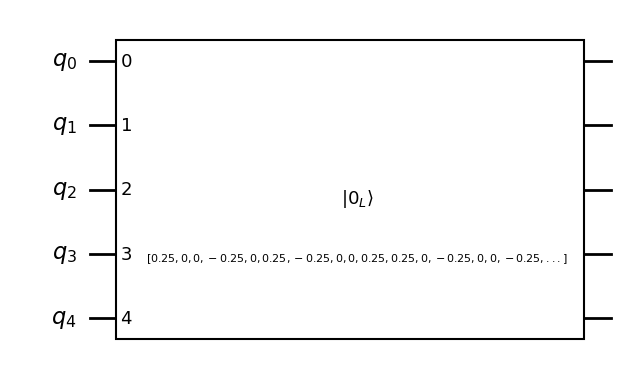

In [5]:
logical_state(0).draw(output = "mpl", style = "bw")

## Syndrome Extraction

Next we need to extract the syndromes of the $[[5,1,3]]$ code. According to [Quantum Error Correction: An Introductor Guide](https://iontrap.duke.edu/files/2025/03/arxiv_sub_v2.pdf), for any quantum error correcting code $[[n,k,d]]$, the syndromes can be extracted from a quantum circuit consisting of $n$ physical qubits (making up the data register) and $n-k$ ancillas (making up the ancilla register) after performing the following steps:

0. Encode the logical quantum state $|\psi_L\rangle$ on the data register
1. Apply Hadamard gate on each ancilla
2. For i=1,2,...,n-k, apply stabilizer P_i on the data register, controlled according the $i^{th}$ ancilla
3. Apply Hadamard gate on each ancilla
4. Measure each ancilla

We already did step 0. in the previous section (only for $|0_L\rangle$ and $|1_L\rangle$, since they are the only two states we care about). Below we define a function that takes $x\in \{0,1\}$ as input, and outputs the circuit outlined above for the code $[[5,1,3]]$, with the encoded logical state mentioned in step 0. being $|x_L\rangle$.  

In [6]:
def syndrome_extraction_circuit(x):
    qr = QuantumRegister(5, "q")
    ar = AncillaRegister(4, "a")
    cr = ClassicalRegister(4, "c")

    qc = QuantumCircuit(qr, ar, cr)
    
    # Encode logical state |x_L>
    qc.compose(logical_state(x), qr, inplace = True)
    
    # Apply Hadamard gates to ancillas
    for i in range(4):
        qc.h(ar[i])
        
    qc.barrier()
    
    # List of stabilizers
    generators = [
        Pauli("XZZXI"),  # P_1 
        Pauli("IXZZX"),  # P_2 
        Pauli("XIXZZ"),  # P_3 
        Pauli("ZXIXZ")   # P_4 
    ]
    
    # Implement controlled Pauli gates
    j = 1
    for pauli in generators:
        # Convert Pauli string to its matrix form
        stab = pauli.to_matrix()
        
        # Convert Pauli matrix product into unitary gate to be used in circuit
        stab_gate = UnitaryGate(stab, label=f"P_{j}: {pauli}")
        
        # Create controlled gate out Pauli matrix product gate
        controlled_stab_gate = stab_gate.control(1)
    
        # Apply the controlled gate to the quantum circuit, with the control being the ancilla a_{j-1}
        qc.append(controlled_stab_gate, [ar[j-1]] + qr[:])
        j += 1
    
    qc.barrier()
    
    # Apply Hadamard gates to ancillas again
    for i in range(4):
        qc.h(ar[i])
    
    # Measure ancillas and store as classical bits
    qc.measure(ar, cr)
        
    return qc

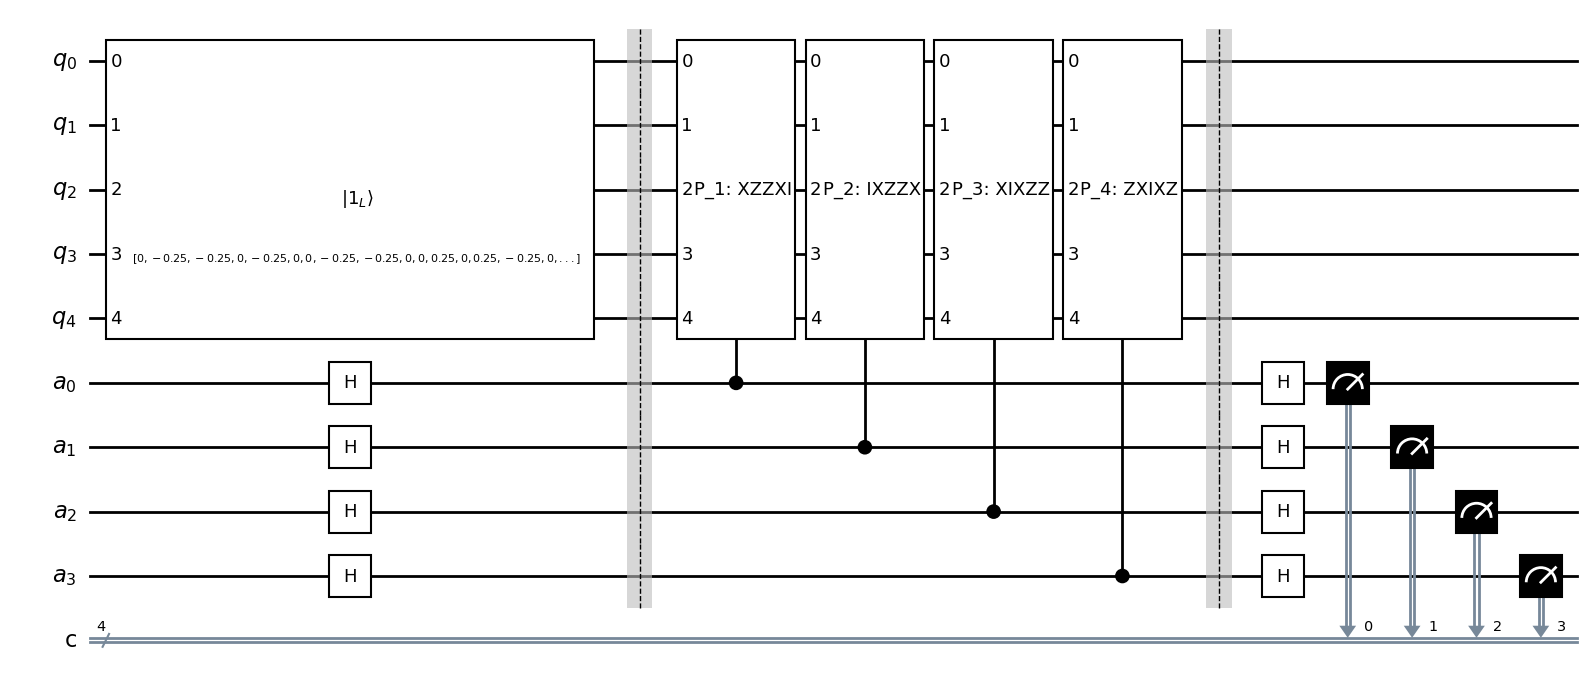

In [7]:
syndrome_extraction_circuit(1).draw(output = "mpl", style = "bw")

## Circuit Fixes

In [Perfect Quantum Error Correction Code](https://arxiv.org/pdf/quant-ph/9602019) by Laflamme et al. they provide a table prescribing the needed circuit correction given each of the possible syndrome measurements that our circuit above could measure. 
| Syndrome | Correction |
|:--------:|:----------:|
| (0,0,0,0) | Do nothing |
| (0,0,0,1) | X on 2nd qubit | 
| (0,0,1,0) | Z on 4th qubit |
| (0,0,1,1) | X on 5th qubit |
| (0,1,0,0) | Z on 2nd qubit | 
| (0,1,0,1) | Y on 2nd qubit |
| (0,1,1,0) | X on 1st qubit |
| (0,1,1,1) | X on 3rd qubit |
| (1,0,0,0) | Z on 1st qubit |
| (1,0,0,1) | Y on 4th qubit |
| (1,0,1,0) | Z on 3rd qubit |
| (1,0,1,1) | X on 4th qubit |
| (1,1,0,0) | Z on 5th qubit |
| (1,1,0,1) | Y on 3rd qubit |
| (1,1,1,0) | Y on 1st qubit |
| (1,1,1,1) | Y on 5th qubit |

Using this table, we now update the syndrome_extraction_circuit function so that it implements the above corrections based on the syndrome measurements recorded. 

In [8]:
def syndrome_extraction_and_correction_circuit(x):
    qr = QuantumRegister(5, "q")
    ar = AncillaRegister(4, "a")
    cr = ClassicalRegister(4, "c")

    qc = QuantumCircuit(qr, ar, cr)
    
    # Encode logical state |x_L>
    qc.compose(logical_state(x), qr, inplace=True)
    
    # Apply Hadamard gates to ancillas
    for i in range(4):
        qc.h(ar[i])
        
    qc.barrier()
    
    # List of stabilizers
    generators = [
        Pauli("XZZXI"),  # P_1 
        Pauli("IXZZX"),  # P_2 
        Pauli("XIXZZ"),  # P_3 
        Pauli("ZXIXZ")   # P_4 
    ]
    
    # Implement controlled Pauli gates
    j = 1
    for pauli in generators:
        stab = pauli.to_matrix()
        stab_gate = UnitaryGate(stab, label=f"P_{j}: {pauli}")
        controlled_stab_gate = stab_gate.control(1)
        qc.append(controlled_stab_gate, [ar[j-1]] + qr[:])
        j += 1
    
    qc.barrier()
    
    # Apply Hadamard gates to ancillas again
    for i in range(4):
        qc.h(ar[i])
    
    # Measure ancillas and store as classical bits
    qc.measure(ar, cr)
    
    qc.barrier()
    
    # Syndrome to correction map (syndrome bits as integer): (Pauli, qubit index)
    correction_table = {
        0b0001: ('x', 1),
        0b0010: ('z', 3),
        0b0011: ('x', 4),
        0b0100: ('z', 1),
        0b0101: ('y', 1),
        0b0110: ('x', 0),
        0b0111: ('x', 2),
        0b1000: ('z', 0),
        0b1001: ('y', 3),
        0b1010: ('z', 2),
        0b1011: ('x', 3),
        0b1100: ('z', 4),
        0b1101: ('y', 2),
        0b1110: ('y', 0),
        0b1111: ('y', 4)
    }
    
    # Apply conditional corrections using if_test()
    for syndrome_val, (gate, qubit_idx) in correction_table.items():  # iterate though each key and value in the correction_table dictionary
        bits = []
        # protocol to obtain bits for each syndrome measurement
        for i in range(3, -1, -1):  
            bit = (syndrome_val >> i) & 1
            bits.append(bit)
        
        # Check which bit the syndrome measurement matches, then apply gate correction
        with qc.if_test((cr[0], bits[0])):
            with qc.if_test((cr[1], bits[1])):
                with qc.if_test((cr[2], bits[2])):
                    with qc.if_test((cr[3], bits[3])):
                        if gate == 'x':
                            qc.x(qr[qubit_idx])
                        elif gate == 'y':
                            qc.y(qr[qubit_idx])
                        elif gate == 'z':
                            qc.z(qr[qubit_idx])

    
    return qc

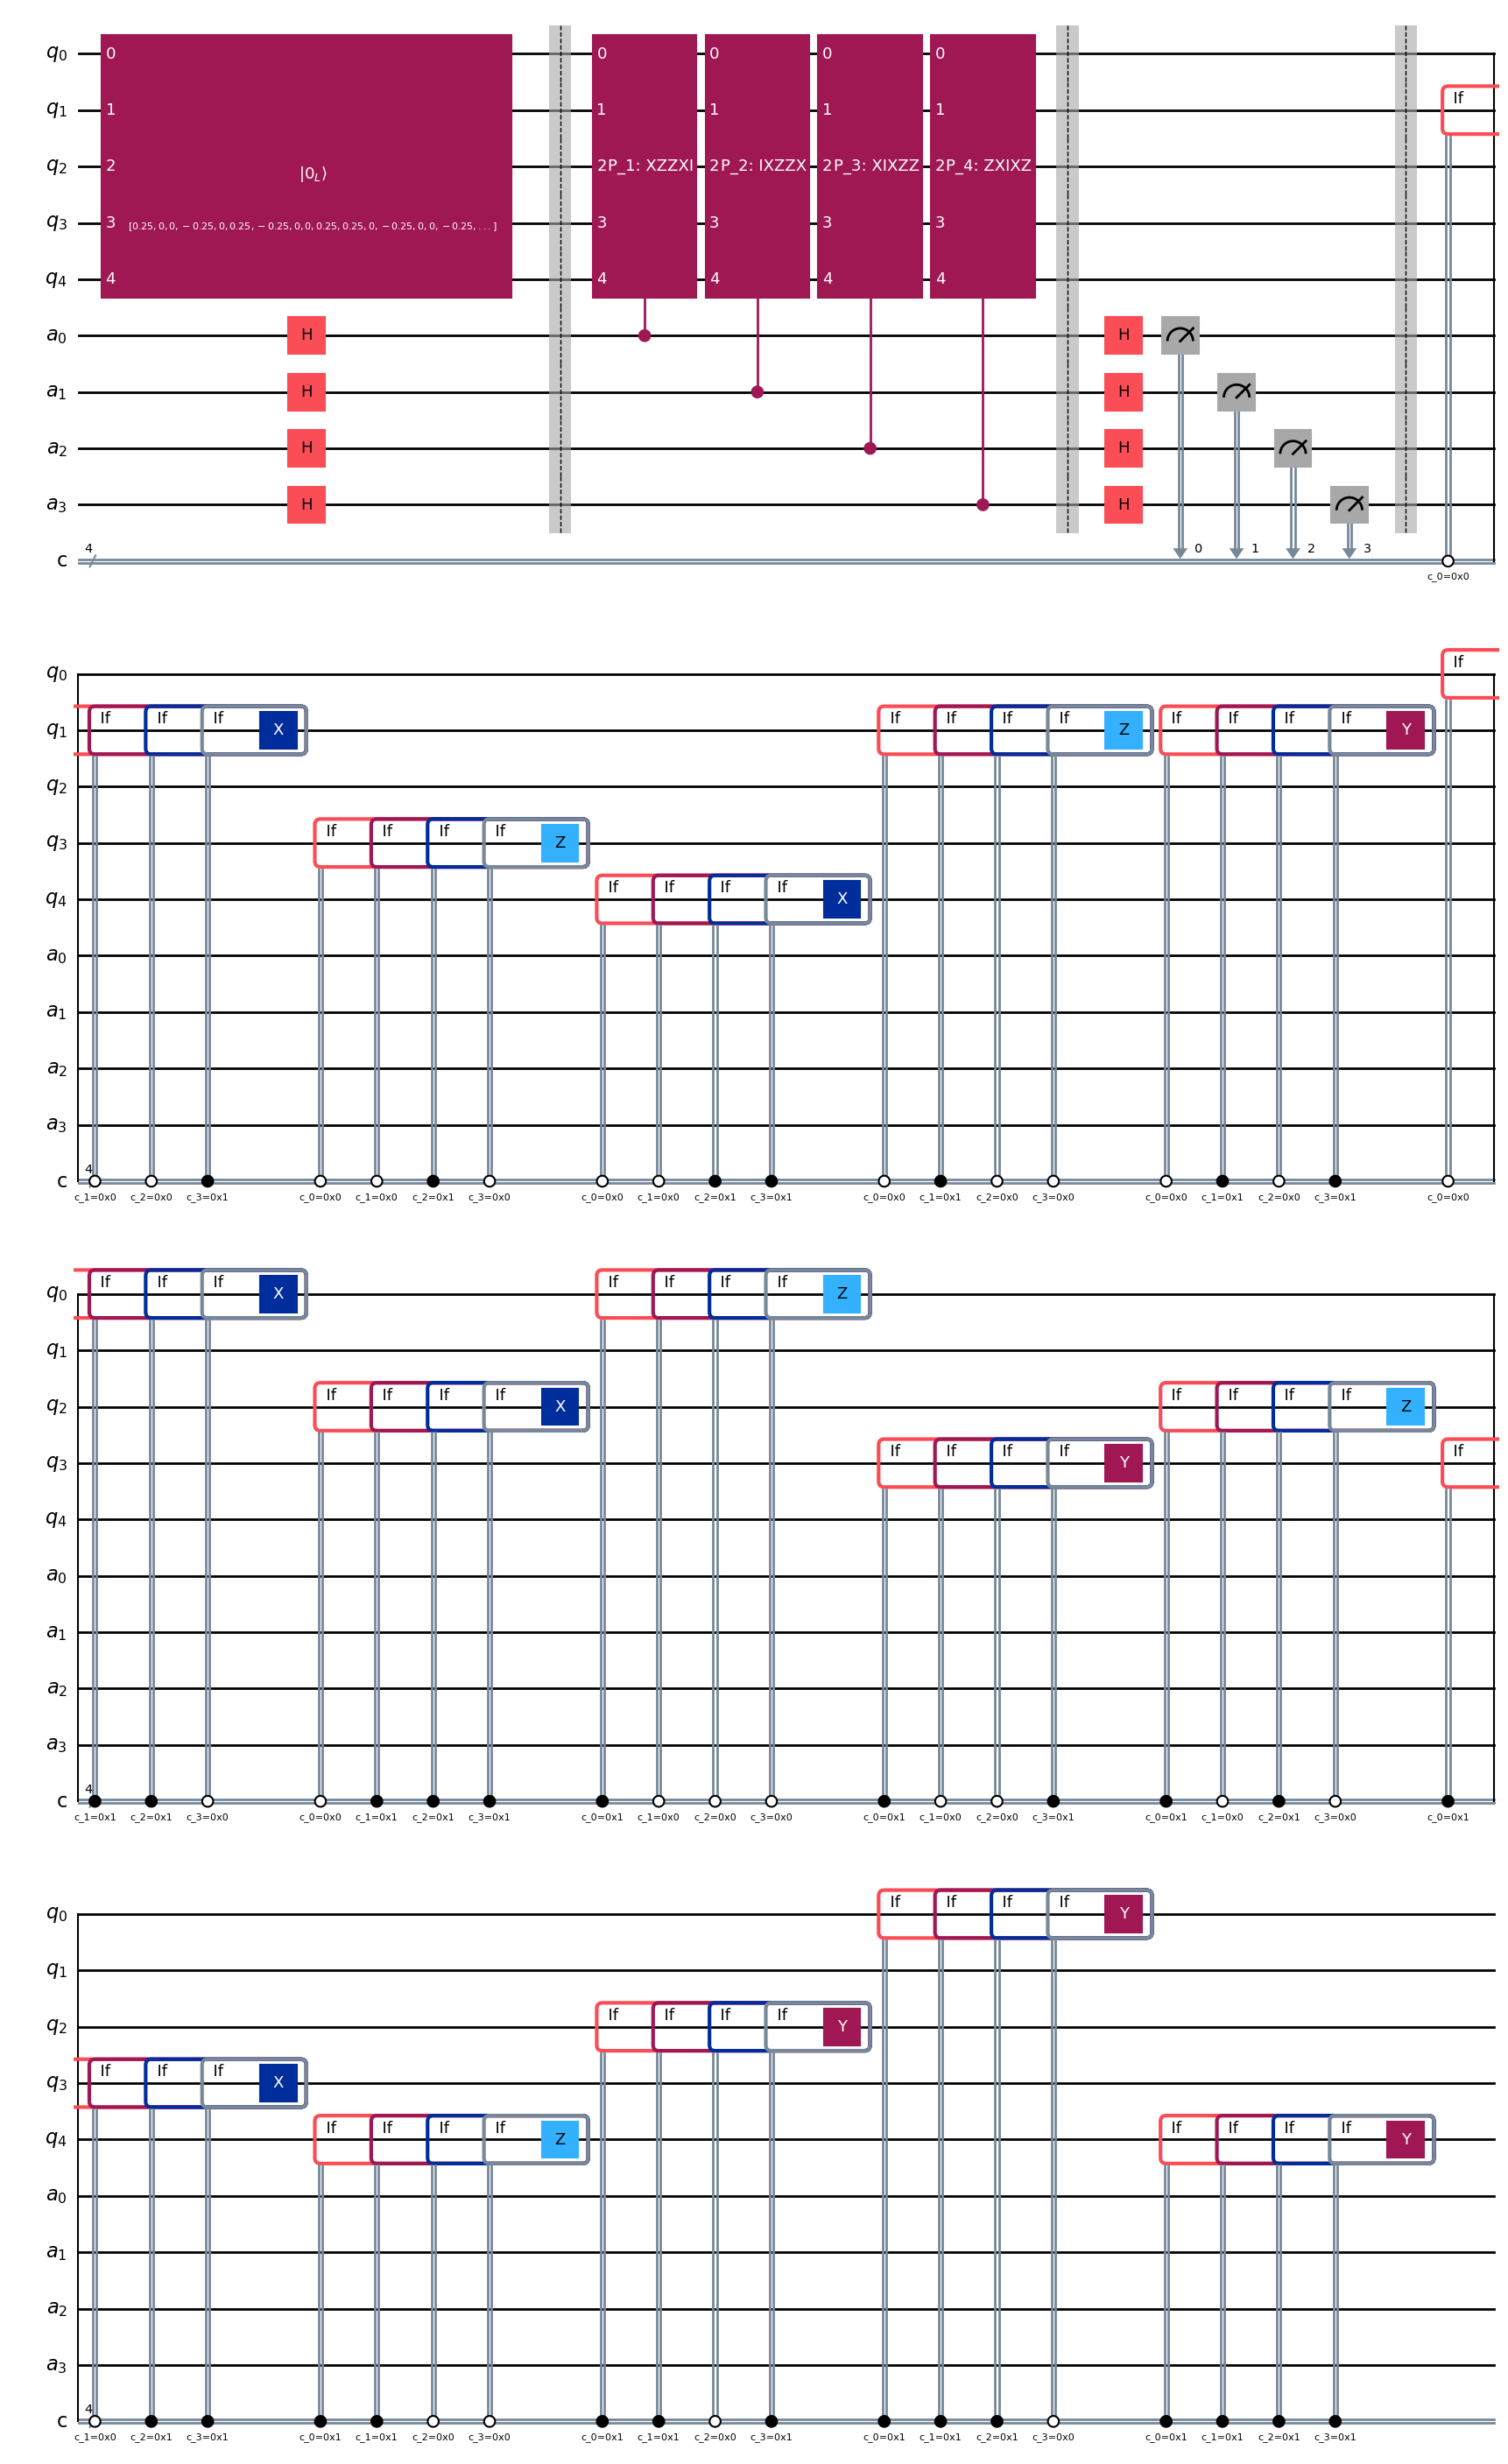

In [9]:
qc = syndrome_extraction_and_correction_circuit(0)
qc.draw('mpl')

Below we simulate the circuit numerous times. Since no errors have been introduced (yet), all 32 simulations should measure the syndrome $(0,0,0,0)$. 

In [10]:
sim = AerSimulator()

qc = syndrome_extraction_and_correction_circuit(0)
compiled_circuit = transpile(qc, sim)
result = sim.run(compiled_circuit, shots=32).result()
counts = result.get_counts()
print(counts)

{'0000': 32}


## Introducing Error

Next we introduce error into our model. Below we define a Pauli error channel with the probability for $X$, $Y$, or $Z$ error equal to $p\leq \frac{1}{3}$. 

In [11]:
def apply_random_pauli_error(qc, qubit, p):
    error = np.random.choice(['X', 'Y', 'Z', 'I'], p=[p, p, p, 1 - 3*p])  # probabilities for each error
    if error == 'X':
        qc.x(qubit)
    elif error == 'Y':
        qc.y(qubit)
    elif error == 'Z':
        qc.z(qubit)
    else:  # If identity do nothing
        pass

Next we update the syndrome_extraction_circuit function, this time applying the Pauli error channel to our circuit to introduce possible error. 

In [12]:
def syndrome_extraction_and_correction_circuit_with_error(x, p):
    qr = QuantumRegister(5, "q")
    ar = AncillaRegister(4, "a")
    cr = ClassicalRegister(4, "c")

    qc = QuantumCircuit(qr, ar, cr)
    
    # Encode logical state |x_L>
    qc.compose(logical_state(x), qr, inplace=True)
    
    # Apply Pauli error channel on circuit
    for i in range(5):
        apply_random_pauli_error(qc, qr[i], p)
    
    # Apply Hadamard gates to ancillas
    for i in range(4):
        qc.h(ar[i])
        
    qc.barrier()
    
    # List of stabilizers
    generators = [
        Pauli("XZZXI"),  # P_1 
        Pauli("IXZZX"),  # P_2 
        Pauli("XIXZZ"),  # P_3 
        Pauli("ZXIXZ")   # P_4 
    ]
    
    j = 1
    for pauli in generators:
        stab = pauli.to_matrix()
        stab_gate = UnitaryGate(stab, label=f"P_{j}: {pauli}")
        controlled_stab_gate = stab_gate.control(1)
        qc.append(controlled_stab_gate, [ar[j-1]] + qr[:])
        j += 1
    
    qc.barrier()
    
    # Apply Hadamard gates to ancillas again
    for i in range(4):
        qc.h(ar[i])
    
    # Measure ancillas and store as classical bits
    qc.measure(ar, cr)
    
    qc.barrier()
    
    # Syndrome to correction map (syndrome bits as integer): (Pauli, qubit index)
    correction_table = {
        0b0001: ('x', 1),
        0b0010: ('z', 3),
        0b0011: ('x', 4),
        0b0100: ('z', 1),
        0b0101: ('y', 1),
        0b0110: ('x', 0),
        0b0111: ('x', 2),
        0b1000: ('z', 0),
        0b1001: ('y', 3),
        0b1010: ('z', 2),
        0b1011: ('x', 3),
        0b1100: ('z', 4),
        0b1101: ('y', 2),
        0b1110: ('y', 0),
        0b1111: ('y', 4)
    }
    
    # Apply conditional corrections using if_test()
    for syndrome_val, (gate, qubit_idx) in correction_table.items():  # iterate though each key and value in the correction_table dictionary
        bits = []
        # protocol to obtain bits for each syndrome measurement
        for i in range(3, -1, -1):  
            bit = (syndrome_val >> i) & 1
            bits.append(bit)
        
        # Check which bit the syndrome measurement matches, then apply gate correction
        with qc.if_test((cr[0], bits[0])):
            with qc.if_test((cr[1], bits[1])):
                with qc.if_test((cr[2], bits[2])):
                    with qc.if_test((cr[3], bits[3])):
                        if gate == 'x':
                            qc.x(qr[qubit_idx])
                        elif gate == 'y':
                            qc.y(qr[qubit_idx])
                        elif gate == 'z':
                            qc.z(qr[qubit_idx])
    

    return qc

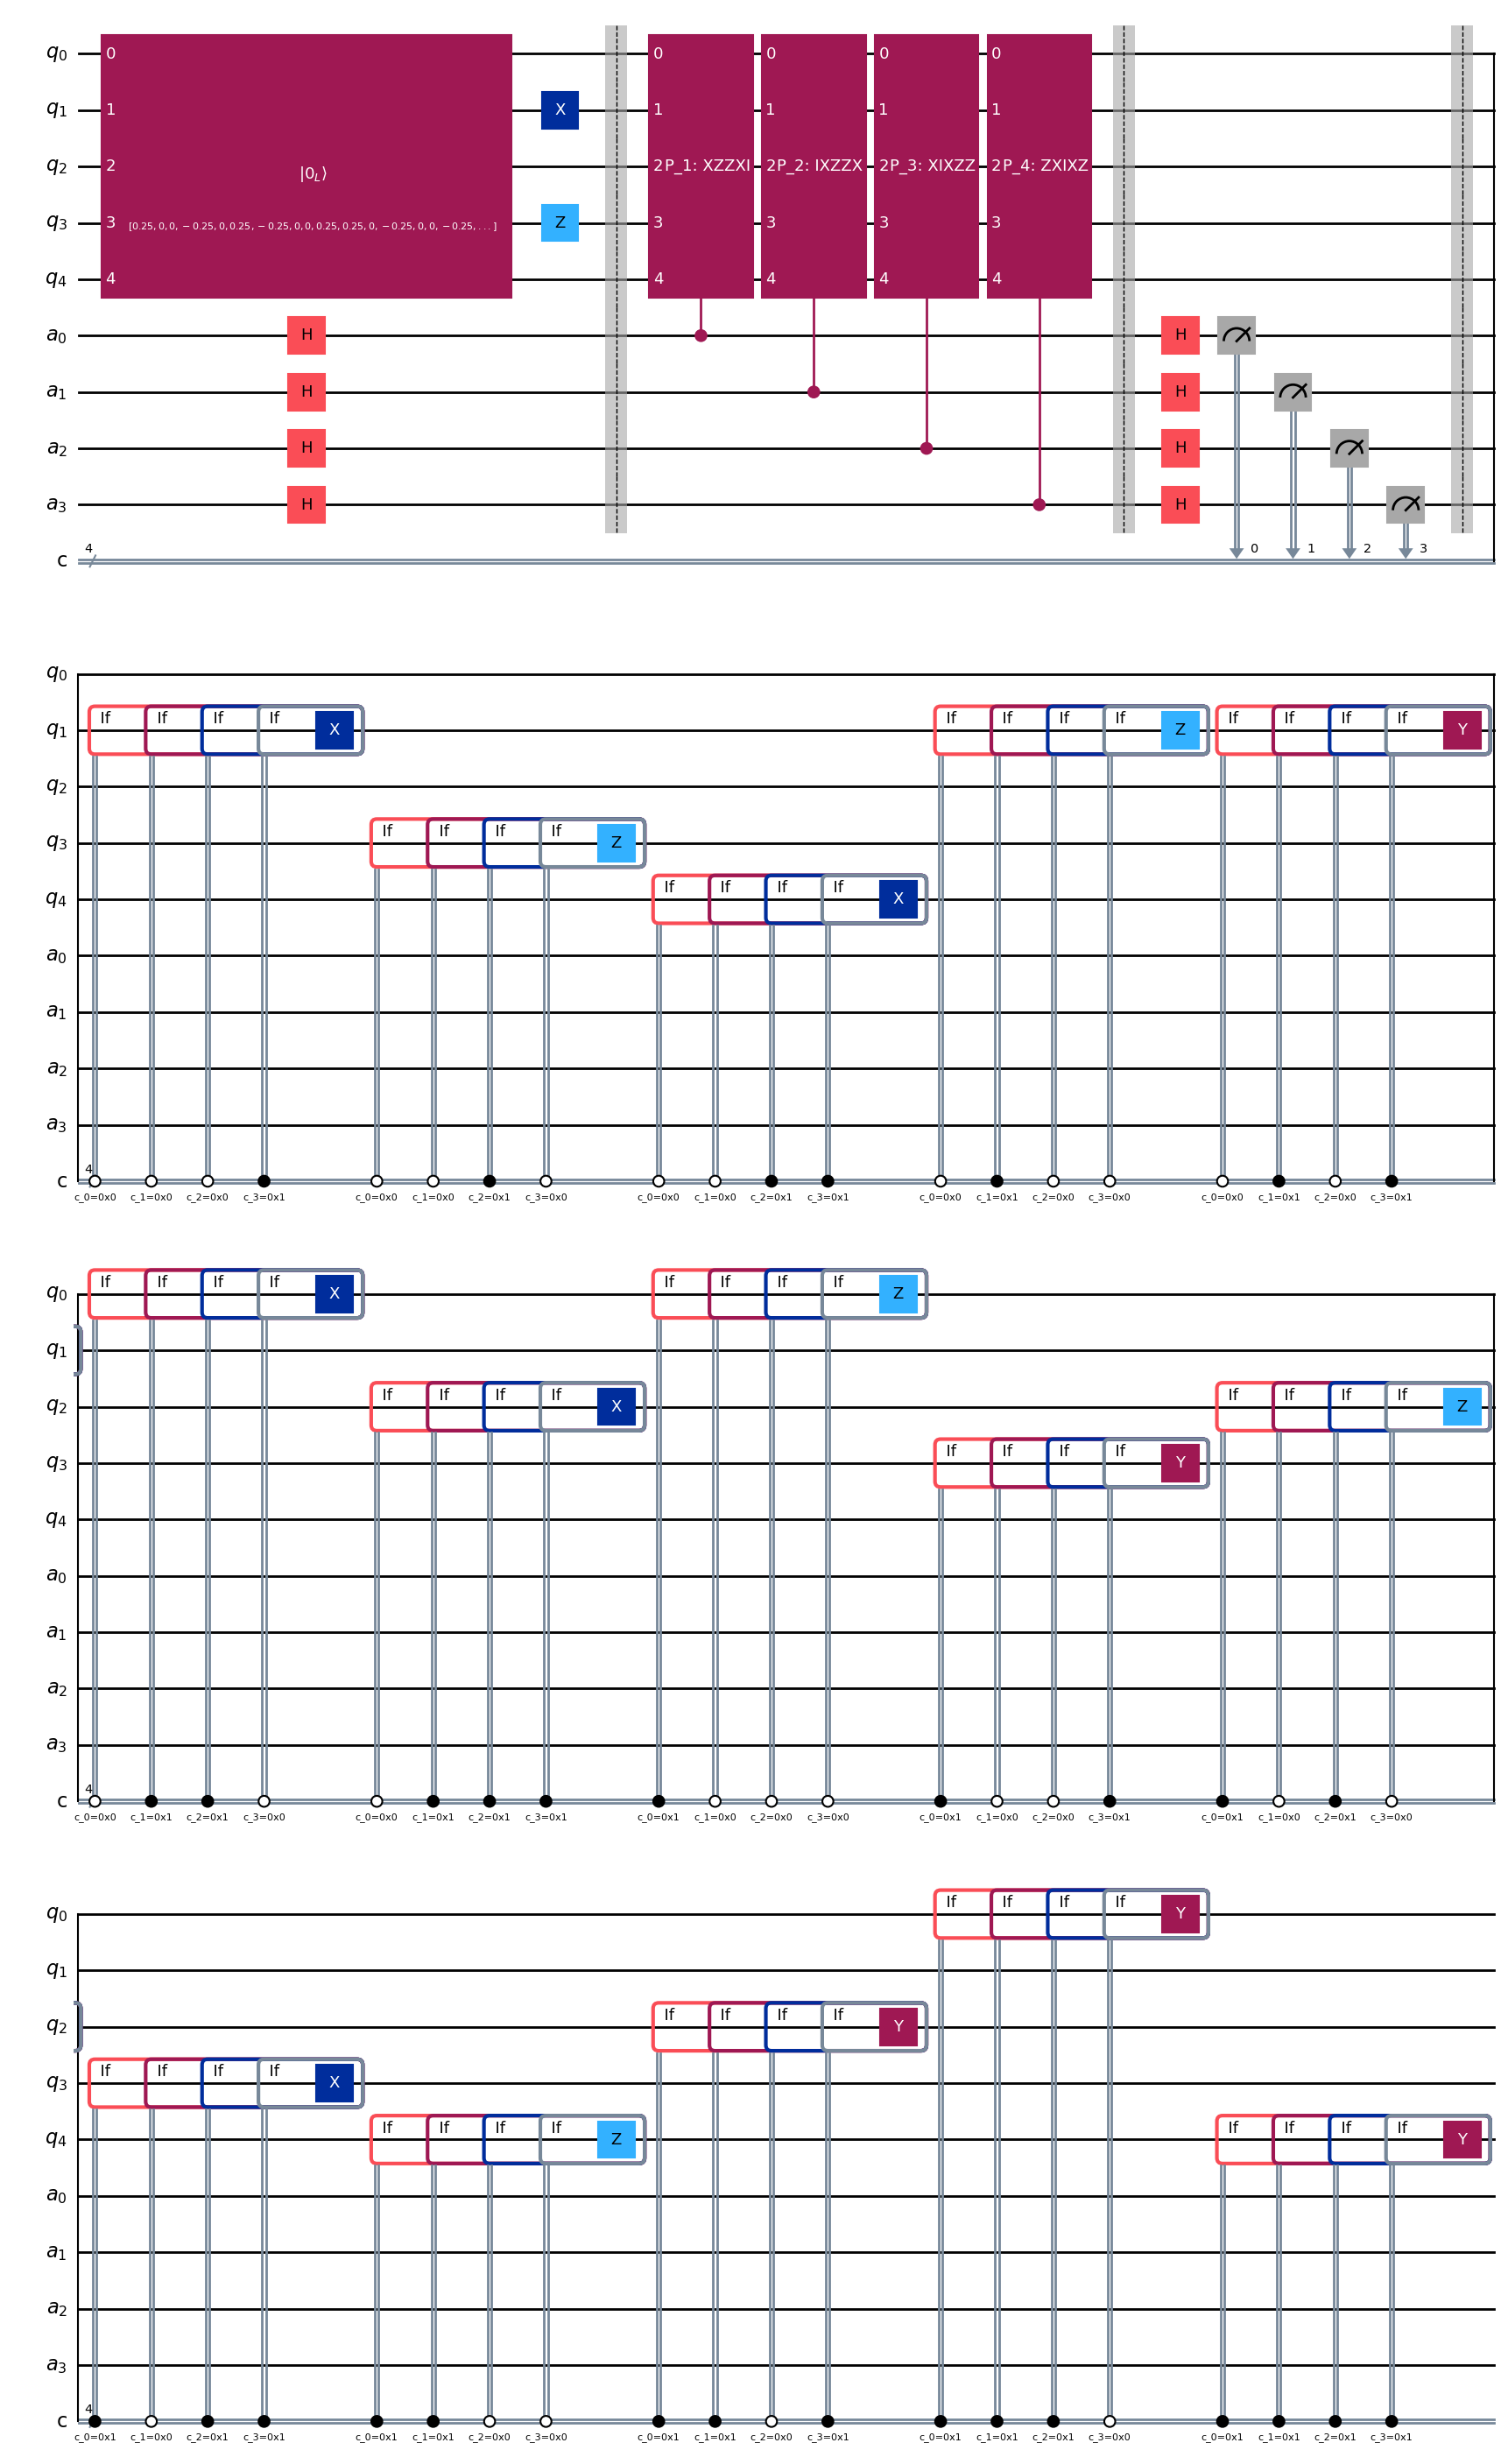

In [13]:
qc = syndrome_extraction_and_correction_circuit_with_error(0, 0.1)
qc.draw('mpl')

Below we run 32 simulations of the above circuit with choice of $x$ and $p$. Each simulation will apply the apply the Pauli error channel, measure syndromes, and then apply correction. Then after that we construct a dictionary recording each syndrome measurement and how many times it occurred. 

In [14]:
# WARNING: This takes about 1 minute and 5 seconds to run
all_results = []

for i in range(32):
    qc = syndrome_extraction_and_correction_circuit_with_error(x=0, p=0.05)
    compiled_circuit = transpile(qc, sim)
    counts = sim.run(compiled_circuit, shots=1).result().get_counts()
    all_results.append(next(iter(counts)))

final_counts = {}
for outcome in all_results:
    if outcome in final_counts:
        final_counts[outcome] += 1
    else:
        final_counts[outcome] = 1

print("Logical qubit results (with correction):", final_counts)

Logical qubit results (with correction): {'0000': 12, '0011': 1, '1111': 1, '0111': 2, '1110': 3, '0110': 1, '0100': 3, '1101': 1, '0010': 3, '0001': 2, '1001': 2, '1100': 1}


A histogram easily shows the distribution of syndrome measurements. Note that 0000 is the most frequently occurring measurement; that is because we set $p=0.05$, but as $p$ increases it will occur less frequently. 

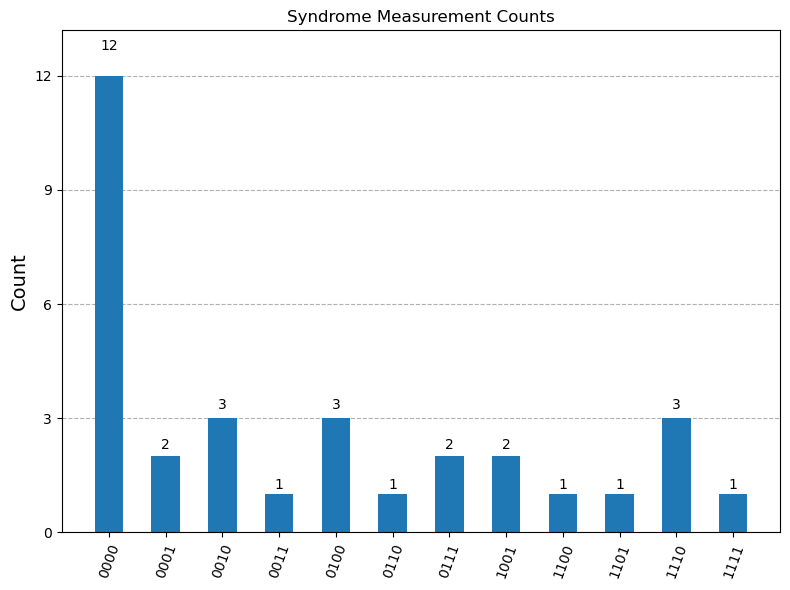

In [15]:
plot_histogram(final_counts, title="Syndrome Measurement Counts", figsize=(8,6))

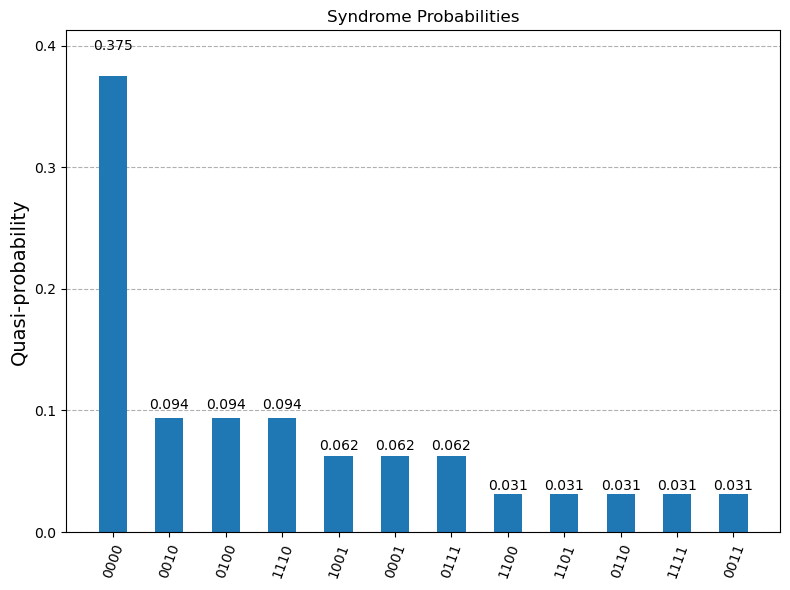

In [16]:
total = sum(final_counts.values())
probs = {}
for s, v in final_counts.items():
    probs[s] = v / total


from qiskit.visualization import plot_histogram

plot_histogram(probs, title="Syndrome Probabilities", sort='value_desc', bar_labels=True, figsize=(8,6))

Lastly here is a histogram showing the probability quasi-probability of success (i.e. the syndrome measuring 0000) for various probability values for p. 

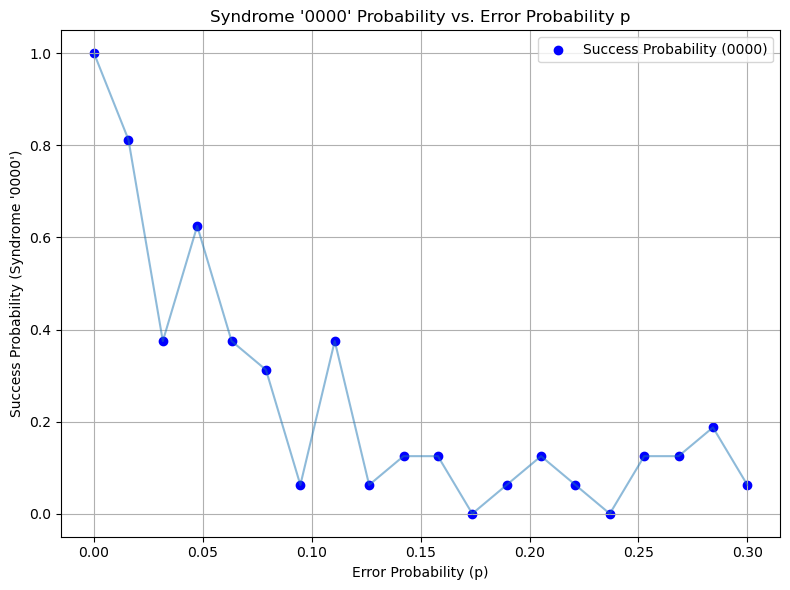

In [19]:
# WARNING: THIS TAKES ABOUT 11 MINUTES TO RUN, EVEN AFTER HALVING THE NUMBER OF SHOTS TO OBTAIN THE QUASI-PROBABILITY OF SUCCESS

# Define the range of error probabilities (p)
p_values = np.linspace(0, 0.3, 20)  # 20 points from 0 to 0.3
shots_per_p = 16  # Reduce from 32 to 16 because otherwise this will take a very long time to run

# Store success probabilities for each p
success_probs = []

for p in p_values:
    all_results = []

    for i in range(shots_per_p):
        qc = syndrome_extraction_and_correction_circuit_with_error(x=0, p=p)
        compiled_circuit = transpile(qc, sim)
        counts = sim.run(compiled_circuit, shots=1).result().get_counts()
        all_results.append(next(iter(counts)))

    # Count occurrences
    final_counts = {}
    for outcome in all_results:
        final_counts[outcome] = final_counts.get(outcome, 0) + 1

    # Calculate probability of syndrome "0000"
    success_prob = final_counts.get("0000", 0) / shots_per_p
    success_probs.append(success_prob)

# Plotting the scatter plot using matplotlib; unfortunately there does not seem to a be a scatter plot function 
# in the qiskit.visualization module
plt.figure(figsize=(8, 6))
plt.scatter(p_values, success_probs, color='blue', label='Success Probability (0000)')
plt.plot(p_values, success_probs, alpha=0.5)
plt.xlabel("Error Probability (p)")
plt.ylabel("Success Probability (Syndrome '0000')")
plt.title("Syndrome '0000' Probability vs. Error Probability p")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()